In [1]:
import drjit as dr
import mitsuba as mi

In [2]:
mi.variants()

['scalar_rgb', 'scalar_spectral', 'cuda_ad_rgb', 'llvm_ad_rgb']

In [3]:
mi.set_variant("cuda_ad_rgb")

In [4]:
scene = mi.load_file("../scenes/cbox_texture.xml", res=128, integrator="prb")

In [5]:
image_ref = mi.render(scene, spp=512)

# Preview the reference image
mi.util.convert_to_bitmap(image_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

In [6]:
config = {
        'render_resolution': (128, 128),
        'texture_resolution': (128, 128),
        'n_upsampling_steps': 4,
        'spp': 32,
        'max_iterations': 500,
        'learning_rate': 7e-4,
}

In [7]:
initial_texture_resolution = [r // (2 ** config['n_upsampling_steps'])
                                for r in config['texture_resolution']]
upsampling_steps = dr.sqr(dr.linspace(mi.Float, 0, 1, config['n_upsampling_steps']+1, endpoint=False).numpy()[1:])
upsampling_steps = (config['max_iterations'] * upsampling_steps).astype(int)
print('The resolution of the texture will be doubled at iterations:', upsampling_steps)

texture = mi.load_dict({
    'type': 'bitmap',
    'id': 'texture',
    'bitmap': mi.Bitmap(0.5 * dr.ones(mi.TensorXf, initial_texture_resolution + [3])),
    'raw': True,
})

# Actually optimized: the texture
params = mi.traverse(texture)
params.keep(['data'])
opt = mi.ad.Adam(lr=config['learning_rate'], params=params)

The resolution of the texture will be doubled at iterations: [ 20  80 180 320]


In [8]:
params_scene = mi.traverse(scene)
key = 'tiles.data'
param_ref = mi.TensorXf(params_scene[key])

def apply_texture():
    dr.enable_grad(params['data'])
    params['data'] = dr.clamp(params['data'], 0, 1)
    params_scene[key] = params["data"]
    params_scene.update()

def mse(image):
    return dr.mean(dr.sqr(image - image_ref))

In [9]:
apply_texture()
image_init = mi.render(scene, spp=512)
mi.util.convert_to_bitmap(image_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

In [10]:
iteration_count = config['max_iterations']
errors = []
scale_factor = 2 ** config['n_upsampling_steps']

for it in range(iteration_count):
    # Apply the texture
    apply_texture()

    # Perform a (noisy) differentiable rendering of the scene
    image = mi.render(scene, params_scene, spp=config["spp"])

    # Evaluate the objective function from the current rendered image
    loss = mse(image)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    # Increase resolution of the heightmap
    if it in upsampling_steps:
        opt['data'] = dr.upsample(opt['data'], scale_factor=(2, 2, 1))
        scale_factor //= 2

    # Update the texture state to the new optimized values
    params.update(opt)

    # Track the difference between the current color and the true value
    err_ref = mse(param_ref - dr.upsample(params['data'], scale_factor=(scale_factor, scale_factor, 1)))
    print(f"Iteration {it:02d}: texture error = {err_ref[0]:6f}\tloss = {loss[0]:6f}", end='\r')
    errors.append(err_ref)
print('\nOptimization complete.')

Iteration 499: texture error = 1.492922	loss = 0.002841
Optimization complete.


In [11]:
image_final = mi.render(scene, spp=512)
mi.util.convert_to_bitmap(image_final)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

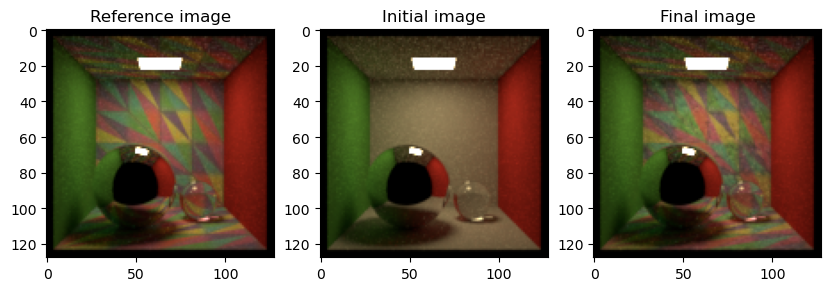

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(mi.util.convert_to_bitmap(image_ref))
plt.title('Reference image')
plt.subplot(1, 3, 2)
plt.imshow(mi.util.convert_to_bitmap(image_init))
plt.title('Initial image')
plt.subplot(1, 3, 3)
plt.imshow(mi.util.convert_to_bitmap(image_final))
plt.title('Final image')
plt.show()

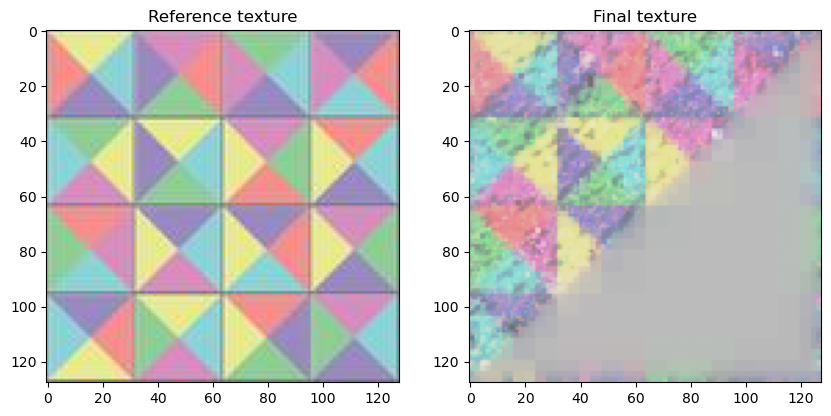

In [13]:
# plot ref and final texture alongside
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(mi.util.convert_to_bitmap(param_ref))
plt.title('Reference texture')
plt.subplot(1, 2, 2)
plt.imshow(mi.util.convert_to_bitmap(params['data']))
plt.title('Final texture')
plt.show()

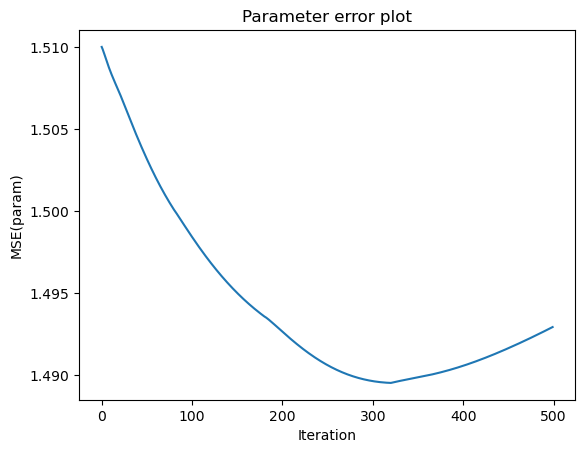

In [14]:
import matplotlib.pyplot as plt
plt.plot(errors)
plt.xlabel('Iteration'); plt.ylabel('MSE(param)'); plt.title('Parameter error plot');
plt.show()